# Reduce 性能报告图表

要求如下：
- 性能图：体现不同parameter配置下的运行时间【横坐标：parameter（10个），纵坐标：时间】
- 不同flops下的性能图【计算密集型算子】【横坐标：flops section（去除小数点），纵坐标：count】
- 不同型号GPU上的性能对比

调整说明：
脚本基于top10并且带Mflops列的CSV设计，部分图带折叠，需要调整`ylim`或者`A`, `B`参数方可正常显示

读入数据，我们起码需要time and flops

In [1]:
import pandas as pd
import csv
import json
import functools

op = 'mean'
device = 'V100'
# 目前已测试的芯片
device_list = ['V100', 'A100', 'P100', 'T4']

def calc_mflops(data):
    if 'Mflops' in data.columns:
        del data['Mflops']
        
    def op_flops_calc(row):
        args = row['parameters']
        args = args.replace('\'', '\"')
        args_list = json.loads(args)

        if len(args_list['input_size'][0]):
            time_in_sec = float(row[4])
            # 数据量计算，需要根据实际情况实现
            size = functools.reduce(lambda a, b: a * b, args_list['input_size'][0])
            return float(size * 1.0 * 1e-6 / time_in_sec)
        
    data.loc[:,"Mflops"] = data.apply(op_flops_calc,axis = 1)
    return data

def get_data_by_dev(_device):
    return calc_mflops(pd.read_csv(f"{_device}/{op}_top10.csv"))

data = get_data_by_dev(device)

def para_flops(data=data, topK=10):
    '''
    我们应该将哪些数据分类呢？出现次数最多的topK
    '''
    g = data.groupby(by='parameters')
    labels = g.size().reset_index(name='count')\
        .sort_values(by=['count'],ascending=(False)).head(topK)
    res = labels.join(data.groupby(by='parameters').agg({'Mflops': 'mean', 'running_time': 'mean'}), on='parameters')
    print("Here's parameter we use:\n", res['parameters'])
    return res

## 性能图(parameter - FLOPs) broken

Here's parameter we use:
 53     {'input_size': [[256]], 'dim': [], 'keepdim': []}
75     {'input_size': [[512]], 'dim': [], 'keepdim': []}
88      {'input_size': [[64]], 'dim': [], 'keepdim': []}
20     {'input_size': [[128]], 'dim': [], 'keepdim': []}
9      {'input_size': [[1024]], 'dim': [], 'keepdim':...
39     {'input_size': [[2048]], 'dim': [], 'keepdim':...
50     {'input_size': [[256, 256, 3, 3]], 'dim': [], ...
5      {'input_size': [[1024, 256, 1, 1]], 'dim': [],...
34       {'input_size': [[1]], 'dim': [], 'keepdim': []}
102     {'input_size': [[96]], 'dim': [], 'keepdim': []}
Name: parameters, dtype: object
53        15.395417
75        30.020479
88         3.773708
20         8.469988
9         65.763331
39       129.878300
50     33259.762230
5      16875.297144
34         0.066967
102        5.941488
Name: Mflops, dtype: float64


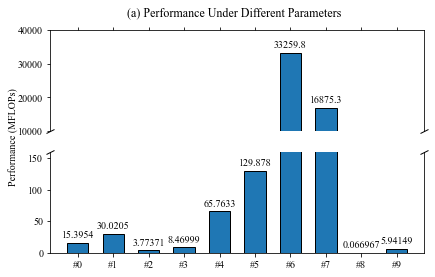

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

'''
data config
'''
flops = para_flops()['Mflops']
print(flops)
labels = [f'#{i}' for i in range(len(flops))]
'''
data config end
'''

# most data at A
A = (0, 160)
# outlines
B = (10000, 40000)

barlabel = True

plt.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rcParams['axes.unicode_minus'] = False
params = {'font.family':'serif',
    'font.serif': 'Times New Roman',
   # 'font.style': 'italic',
    'font.weight': 'normal',  # or 'blod'
   # 'font.size': '12',  # or large,small
}
plt.rcParams.update(params)

x = np.arange(len(flops))
width = 0.6

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

rects1 = ax1.bar(x, flops, width, label='V100', edgecolor='black')
rects2 = ax2.bar(x, flops, width, label='V100', edgecolor='black')

ax1.set_ylim(*B)  # outliers only
ax2.set_ylim(*A)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

fig.text(0, 0.5, 'Performance (MFLOPs)', va='center', rotation='vertical')
plt.suptitle('(a) Performance Under Different Parameters', x=0.525, y=.95, horizontalalignment='center')
ax1.set_xticks(x, labels)

if barlabel:
    ax1.bar_label(rects1, padding=3)
    ax2.bar_label(rects2, padding=3)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.tight_layout()

plt.savefig(f"{op}_a.pdf")

## 性能图（parameter-time）not broken

Here's parameter we use:
 53     {'input_size': [[256]], 'dim': [], 'keepdim': []}
75     {'input_size': [[512]], 'dim': [], 'keepdim': []}
88      {'input_size': [[64]], 'dim': [], 'keepdim': []}
20     {'input_size': [[128]], 'dim': [], 'keepdim': []}
9      {'input_size': [[1024]], 'dim': [], 'keepdim':...
39     {'input_size': [[2048]], 'dim': [], 'keepdim':...
50     {'input_size': [[256, 256, 3, 3]], 'dim': [], ...
5      {'input_size': [[1024, 256, 1, 1]], 'dim': [],...
34       {'input_size': [[1]], 'dim': [], 'keepdim': []}
102     {'input_size': [[96]], 'dim': [], 'keepdim': []}
Name: parameters, dtype: object


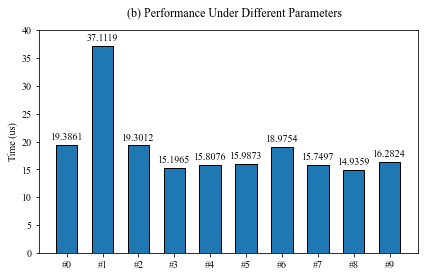

In [3]:
import matplotlib.pyplot as plt
import numpy as np


'''
data config
'''
time = para_flops()['running_time'] * 1000 * 1000
labels = [f'#{i}' for i in range(len(time))]
'''
data config end
'''

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, time, width, label='V100', edgecolor='black')
ax.set_ylim(0, 40)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (us)')
plt.suptitle('(b) Performance Under Different Parameters', x=0.55, y=.95, horizontalalignment='center')
ax.set_xticks(x, labels, text='%.2f')

ax.bar_label(rects, padding=3)

fig.tight_layout()

plt.savefig(f"{op}_b.pdf")

## 性能图（section-count）

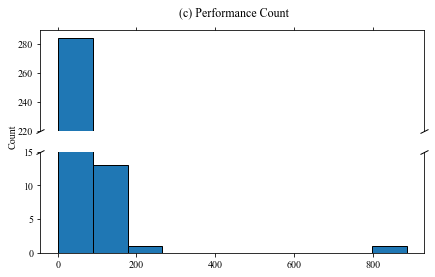

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

'''
data config
'''
flops = data['Mflops'] / 1000 # GFLOPs
'''
data config end
'''

# most data at A
A = (0, 15)
# outlines
B = (220, 290)

barlabel = True

plt.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rcParams['axes.unicode_minus'] = False
params = {'font.family':'serif',
    'font.serif': 'Times New Roman',
   # 'font.style': 'italic',
    'font.weight': 'normal',  # or 'blod'
   # 'font.size': '12',  # or large,small
}
plt.rcParams.update(params)

x = np.arange(len(flops))
width = 0.6

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

rects1 = ax1.hist(flops, edgecolor='black')
rects2 = ax2.hist(flops, edgecolor='black')

ax1.set_ylim(*B)  # outliers only
ax2.set_ylim(*A)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
plt.suptitle('(c) Performance Count', x=0.525, y=.95, horizontalalignment='center')
# ax1.set_xticks(x, labels)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.tight_layout()

plt.savefig(f"{op}_c.pdf")

## 对比图（parameter-time）

Here's parameter we use:
 53    {'input_size': [[256]], 'dim': [], 'keepdim': []}
75    {'input_size': [[512]], 'dim': [], 'keepdim': []}
88     {'input_size': [[64]], 'dim': [], 'keepdim': []}
20    {'input_size': [[128]], 'dim': [], 'keepdim': []}
9     {'input_size': [[1024]], 'dim': [], 'keepdim':...
Name: parameters, dtype: object
Here's parameter we use:
 103       {'input_size': [[]], 'dim': [], 'keepdim': []}
53     {'input_size': [[256]], 'dim': [], 'keepdim': []}
75     {'input_size': [[512]], 'dim': [], 'keepdim': []}
88      {'input_size': [[64]], 'dim': [], 'keepdim': []}
20     {'input_size': [[128]], 'dim': [], 'keepdim': []}
Name: parameters, dtype: object
Here's parameter we use:
 103       {'input_size': [[]], 'dim': [], 'keepdim': []}
53     {'input_size': [[256]], 'dim': [], 'keepdim': []}
75     {'input_size': [[512]], 'dim': [], 'keepdim': []}
88      {'input_size': [[64]], 'dim': [], 'keepdim': []}
20     {'input_size': [[128]], 'dim': [], 'keepdim': []}
Name: pa

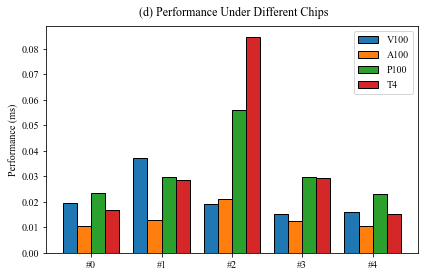

In [5]:
import matplotlib.pyplot as plt
import numpy as np

labels = [f'#{i}' for i in range(5)]
datas = [para_flops(get_data_by_dev(d), topK=5)['running_time'] * 1000 for d in device_list]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
for i, (device, data) in enumerate(zip(device_list, datas)):
    ax.bar(x + (-len(datas) + 2 * i + 1) * width/2, data, width, label=device, edgecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance (ms)')
plt.suptitle('(d) Performance Under Different Chips', x=0.55, y=.95, horizontalalignment='center')
ax.set_xticks(x, labels)
# ax.set_ylim(0, 40)
ax.legend()

fig.tight_layout()

plt.savefig(f"{op}_d.pdf")

## 利用率线图（section-rate）

非访存密集